### Synthetic spectral library of optically thick atmospheres for Little Red Dots (LRDs)

This Ipython notebook explains the synthetic spectral library data and gives visualization examples.

The library contains synthetic spectra of optically thick atmospheres calculated using TLUSTY (Hubeny 1988; Hubeny et al. 2021), with a parameter coverage tailored to LRDs.  If you find this library helpful, we would appreciate a citation to the paper describing this data product: H. Liu et al. 2026, [arxiv:](https://arxiv.org/).

The spectra are controlled by four parameters: effective temperature $T_{\rm eff}$ (in Kelvins), surface gravity $\log g$ (in $\rm cm~s^{-2}$), metallicity $\rm[M/H]$, and microturbulence $\xi_{\rm mtb}$ (in $\rm km~s^{-1}$). Each spectrum is stored in a plain-text file.  The name of the file is in the format of `tXXXXgXXXXzXXvXX.spec` or `tXXXXgXXXXzXXvXX_nograd.spec`.  For example, a spectrum at $T_{\rm eff}=4500{\rm~K}, \log g=-2.75, {\rm[M/H]}=-1, \xi_{\rm mtb}=2.0{\rm~km~s^{-1}}$ corresponds to `t4500g-275z-1v02.spec`.  The suffix `_nograd` indicates model cases with $g_{\rm rad}$ turned off (see paper for details).

In each spectrum file, the first column is the rest-frame wavelength $\lambda$ in Angstroms (range: $2000-40000{\rm~\AA}$), and the second column is the flux $F_\lambda$ in $\rm erg~s^{-1}~cm^{-2}~\AA^{-1}$.

In [1]:
# dependencies
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
import pandas as pd
import os
import seaborn as sns

#### Visualize the model grid; reproduce Fig. 1

               filename  Teff  logg  logz  vtb  grad
0    ./t4000g-300z-2v02  4000  -3.0  -2.0    2  True
1    ./t4000g-250z-2v02  4000  -2.5  -2.0    2  True
2    ./t4000g-200z-2v02  4000  -2.0  -2.0    2  True
3    ./t4000g-150z-2v02  4000  -1.5  -2.0    2  True
4    ./t4000g-100z-2v02  4000  -1.0  -2.0    2  True
..                  ...   ...   ...   ...  ...   ...
228  ./t5000g-050z-1v10  5000  -0.5  -1.0   10  True
229  ./t5000g+000z-1v10  5000   0.0  -1.0   10  True
230  ./t5000g+050z-1v10  5000   0.5  -1.0   10  True
231  ./t5000g+100z-1v10  5000   1.0  -1.0   10  True
232  ./t5000g+150z-1v10  5000   1.5  -1.0   10  True

[233 rows x 6 columns]


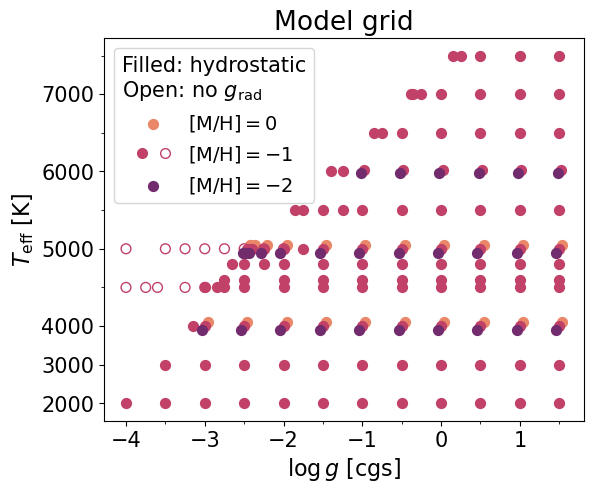

In [ ]:
# -------------------------------------------------------------
# read model file and keep metadata in a Pandas DataFrame
# -------------------------------------------------------------

specdir = './'
# find all spec files with format tXXXXgXXXXzXXvXX.spec
specs_df = pd.DataFrame({})

for file in os.listdir(specdir):
    if file.endswith('.spec'):
        parts = file.split('_')[0]
        new_row = {'filename': specdir + file[:-5],
                   'Teff': int(parts[1:5]),         # effetive temperature T_eff
                   'logg': int(parts[6:10])/100,    # log surface gravity log g
                   'logz': float(parts[11:13]),     # log metallicity [M/H]
                   'vtb': int(parts[14:16]),        # microturbulence velocity xi_mtb
                   'grad': False if 'nograd' in file else True,}
        specs_df = pd.concat([specs_df, pd.DataFrame([new_row])], ignore_index=True)
specs_df = specs_df.sort_values(by=['vtb','logz', 'Teff', 'logg']).reset_index(drop=True)
print(specs_df)

# -------------------------------------------------------------
# visualize the model grid in logg-Teff space, color-coded by 
# metallicity and marked by whether g_rad is included
# -------------------------------------------------------------
grouped = specs_df.groupby(['logg', 'Teff', 'grad', 'vtb'])
x_plot, y_plot, z_plot, prad_plot = [], [], [], []
dx = 0.04   # spacing in logg
dy = 50.0   # spacing in Teff

for (logg, teff, grad, vtb), group in grouped:
    n = len(group)
    # only visualize vtb=2 km/s models to avoid overcrowding
    if vtb == 10:
        continue
    # move T=2000 K and 3000 K models up to save space
    if teff == 2000:
        teff += 1000
    elif teff == 3000:
        teff += 500
    # offsets centered around zero
    offsets = np.linspace(-(n-1)/2, (n-1)/2, n)
    for i, (_, row) in enumerate(group.iterrows()):
        x_plot.append(logg + offsets[i] * dx)
        y_plot.append(teff + offsets[i] * dy)
        z_plot.append(row['logz'])
        prad_plot.append(grad)
x_plot = np.array(x_plot)
y_plot = np.array(y_plot)
z_plot = np.array(z_plot)
prad_plot = np.array(prad_plot)

fig0, ax0 = plt.subplots()
palette = sns.color_palette('flare', n_colors=5)
sc = ax0.scatter(x_plot[z_plot==0], y_plot[z_plot==0], s=50, color=palette[0], label=r'$\rm [M/H] = 0$')
ax0.scatter(x_plot[(z_plot==-1) & (prad_plot)], y_plot[(z_plot==-1) & (prad_plot)], s=50, color=palette[2])
ax0.scatter(x_plot[(z_plot==-1) & (~prad_plot)], y_plot[(z_plot==-1) & (~prad_plot)], s=50, facecolors='none', edgecolors=palette[2])
sc2 = ax0.scatter(x_plot[z_plot==-2], y_plot[z_plot==-2], s=50, color=palette[4], label=r'$\rm [M/H] = -2$')
ax0.set_xlabel(r'$\log g$ [cgs]', fontsize=16)
ax0.set_ylabel(r'$T_{\rm eff}$ [K]', fontsize=16)
ax0.set_yticks([3000,3500,4000,5000,6000,7000],labels=['2000','3000','4000','5000','6000','7000'])
ax0.set_title('Model grid', fontsize=19)
ax0.tick_params(axis='both', which='major', labelsize=15)
ax0.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax0.yaxis.set_minor_locator(plt.MultipleLocator(500))
# Proxy legend artists (perfectly aligned)
filled_proxy = Line2D([], [], marker='o', markersize=7, linestyle='None',markerfacecolor=palette[2], markeredgecolor=palette[2])
empty_proxy = Line2D([], [], marker='o', markersize=7, linestyle='None',markerfacecolor='none', markeredgecolor=palette[2])
ax0.legend(
    [sc, (filled_proxy, empty_proxy), sc2],
    [r'$\rm [M/H] = 0$', r'$\rm [M/H] = -1$', r'$\rm [M/H] = -2$'],
    handler_map={tuple: HandlerTuple(ndivide=None),},
    fontsize=14,
    title='Filled: hydrostatic\n'+r'Open: no $g_{\rm rad}$',title_fontsize=15
)
fig0.subplots_adjust(left=0.15,bottom=0.123,top=0.92)

#### Visualize a synthetic spectrum

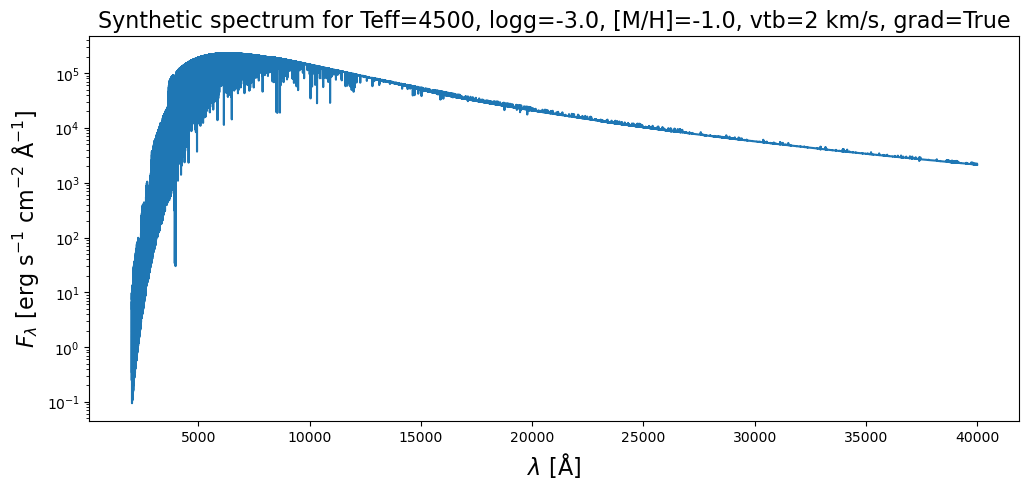

In [14]:
# function to find a spec file given parameters and return wavelength and flux arrays
def find_spec_file(teff, logg, logz, vtb, grad, specdir):
    filename = 't{:04d}g{:+04.0f}z{:+02.0f}v{:02d}{}.spec'.format(
        teff, int(logg*100), int(logz), vtb, '' if grad else '_nograd')
    filepath = os.path.join(specdir, filename)
    if os.path.exists(filepath):
        data = np.loadtxt(filepath)
        return data[:,0], data[:,1]
    else:
        print('File not found:', filepath)
        return None, None

teff, logg, logz, vtb, grad = 4500, -3.0, -1.0, 2, True
wave_arr, flux_arr = find_spec_file(teff, logg, logz, vtb, grad, specdir)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(wave_arr, flux_arr)
ax.set_title('Synthetic spectrum for Teff={}, logg={}, [M/H]={}, vtb={} km/s, grad={}'.format(
    teff, logg, logz, vtb, grad), fontsize=16)
ax.set_xlabel(r'$\lambda~[\rm\AA]$', fontsize=16)
ax.set_ylabel(r'$F_\lambda~[\rm erg~s^{-1}~cm^{-2}~\AA^{-1}]$', fontsize=16)
ax.set_yscale('log')